In [1]:
%matplotlib inline
import nest_asyncio
nest_asyncio.apply()

import multiprocessing
multiprocessing.set_start_method("fork")

import pickle
import os
import math
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import statsmodels
import stan
import arviz as az
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel
import scipy
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Synthetic Data Generation

In [2]:
num_country = 5
site_lengths = []
column_names = ["country_number","site_number","number_recruited", "week"]
df = pd.DataFrame(columns = column_names)
site_num=0
for i in range(num_country):
    num_sites = np.random.randint(5,10)
    site_idx = np.arange(num_sites)
    site_rep = np.random.randint(1,4)
    for j in range(num_sites):
        site_num += 1
        site_multiplier =np.random.normal(1,0.1)

        for k in range(site_rep):
            site_length = np.random.randint(3,30)
            if site_length >= 16 :
                site_length += np.random.randint(1,50)

            country_idx = (np.full(site_length, i)).astype('int')
            site_idx = (np.full(site_length, site_num)).astype('int')
            temp_x = (np.arange(site_length)).astype('float')
            if i == 0:
                intensity = site_multiplier * np.exp(-0.001*temp_x**2+0.007*temp_x)+.2
            elif i == 1 :
                intensity = site_multiplier * np.exp(-0.001*temp_x**2+0.025*temp_x)+.2
            elif i == 2 :
                intensity = site_multiplier * np.exp(-0.004*temp_x**2+0.25*temp_x-4.5)+.6
            elif i == 3 :
                intensity = site_multiplier * np.exp(-.0001*temp_x**2+0.01*temp_x-0.7)+.5
            elif i == 4 :
                intensity = site_multiplier * np.exp(-.0005*temp_x**2+0.05*temp_x-1.5)+.3

            number_recruited = (np.random.poisson(intensity)).astype('float')
            d = dict(country_number = country_idx, site_number = site_idx, number_recruited = number_recruited, week = temp_x+1)
            df_site = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
            df = df.append(df_site, ignore_index = True)

In [4]:
df.groupby(['country_number'])['week'].count()

country_number
0    684
1    659
2    471
3    347
4    283
Name: week, dtype: int64

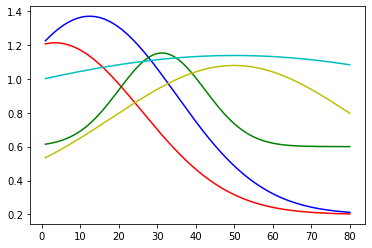

In [5]:
x_range = np.linspace(1, 80,250)

intensity1 = np.exp(-0.001*x_range**2+0.007*x_range)+.2
intensity2 = np.exp(-0.001*x_range**2+0.025*x_range)+.2
intensity3 = np.exp(-0.004*x_range**2+0.25*x_range-4.5)+.6
intensity4 = np.exp(-.0001*x_range**2+0.01*x_range-0.7)+.5
intensity5 = np.exp(-.0005*x_range**2+0.05*x_range-1.5)+.3

plt.plot(x_range, intensity1, '-r')
plt.plot(x_range, intensity2, '-b')
plt.plot(x_range, intensity3, '-g')
plt.plot(x_range, intensity4, '-c')
plt.plot(x_range, intensity5, '-y')

In [6]:
# Number of countries
totalN = len(df)
J = len(df.country_number.unique())
S = len(df.site_number.unique())
country = np.reshape((np.array([df.country_number])),(totalN,))+1
site = (np.reshape((np.array([df.site_number])),(totalN,)))
N = list(df.groupby(['country_number']).count().max(axis=1))
maxN = max(df.groupby(['country_number']).count().max(axis=1))
country_of_site = np.array(df.groupby(['country_number','site_number']).size().reset_index()['country_number'])+1

In [7]:
n_tilde = 150
x_tilde = np.zeros((J,n_tilde))
for i in range(J):
    x_tilde[i] = np.linspace(1., df.groupby(['country_number'])['week'].max()[i]+5, n_tilde)

In [8]:
intensity = np.zeros((J,n_tilde))
for i in range(J):
    if i == 0:
        temp_intensity = np.exp(-0.001*x_tilde[i]**2+0.007*x_tilde[i])+.2
    elif i == 1 :
        temp_intensity = np.exp(-0.001*x_tilde[i]**2+0.025*x_tilde[i])+.2
    elif i == 2 :
        temp_intensity = np.exp(-0.004*x_tilde[i]**2+0.25*x_tilde[i]-4.5)+.6
    elif i == 3 : 
        temp_intensity = np.exp(-.0001*x_tilde[i]**2+0.01*x_tilde[i]-0.7)+.5
    elif i == 4 :
        temp_intensity = np.exp(-.0005*x_tilde[i]**2+0.05*x_tilde[i]-1.5)+.3
    intensity[i] = temp_intensity

In [9]:
df[df['country_number']==0]
dfs_to_join_x = []
dfs_to_join_y = []
dfs_to_join_s = []

for j in range(J):
    temp_df = df[df['country_number']==j]
    temp_df_x = pd.DataFrame(temp_df['week'])
    temp_df_y = pd.DataFrame(temp_df['number_recruited'])
    temp_df_s = pd.DataFrame(temp_df['site_number'])

    temp_df_x = temp_df_x.reset_index(drop=True)
    temp_df_y = temp_df_y.reset_index(drop=True)
    temp_df_s = temp_df_s.reset_index(drop=True)

    dfs_to_join_x.append(temp_df_x)
    dfs_to_join_y.append(temp_df_y)
    dfs_to_join_s.append(temp_df_s)

df_to_join_x = pd.concat(dfs_to_join_x, axis=1)
df_to_join_y = pd.concat(dfs_to_join_y, axis=1)
df_to_join_s = pd.concat(dfs_to_join_s, axis=1)


df_to_join_x = df_to_join_x.fillna(0)
df_to_join_y = df_to_join_y.fillna(0)
df_to_join_s = df_to_join_s.fillna(0)

y = np.array(df_to_join_y.T).astype(int)
x = np.array(df_to_join_x.T)
site = np.array(df_to_join_s.T).astype(int)


In [10]:
synth_data = {'J': J, 'maxN': maxN, 'N': N, 'y': y, 'x': x, 'S':S, 'site':site, 'n_tilde':n_tilde, 'country_of_site':country_of_site}